# Environment Setup

## Packages

In [1]:
from folderstats import *
import sys
import pandas as pd
import gc
import humanize
import matplotlib.pyplot as plt
import os

## Parameters

In [2]:
version="07.28.2020"
server_size=274877906944000 #250TB
output_dir=os.path.join("../Analysis", version, "Reports")

In [4]:
#Create output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load Data
The file is really large even after dropping a number of less useful columns (~17Gb) which makes it difficult to work with on the work computer. Ideally I would use the index col parameter in read_csv but I get a warning message. Setting the index after seems to work just fine. In Columns 3 there is a mixed datatype warning which I have to be mindful of because this may cause trouble.

In [6]:
df=pd.read_csv(os.path.join("../Data/", version, "md5sum", "folderstats_combined_md5sums.txt.gz"), sep='\t', compression='gzip', low_memory=True)
df.set_index(["Unnamed: 0"], inplace=True) #Set the first row as the index

e:\dropbox\patryk\lab_notes\projects\server_maintenance\env\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39689811 entries, 0 to 39689810
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   path            object 
 1   name            object 
 2   extension       object 
 3   size            float64
 4   folder          bool   
 5   uid             float64
 6   inode           float64
 7   num_hard_links  float64
 8   md5sum          object 
dtypes: bool(1), float64(4), object(4)
memory usage: 17.4 GB


# Cleanup

### Remove Folders
Each row can correspond to either a file or a folder. It is simplier to remove the folder rows since they would complicate functions that will tally up file sizes.

In [8]:
df=df.loc[df["folder"] == False]

In [9]:
df.folder.value_counts()

False    34177980
Name: folder, dtype: int64

### Null Rows

Most of the Nan/Null entries are the same across the size, uid, inode and num_hard_links columns. All of these files have a FileNotFoundError from the md5sum hashing suggesting that they were deleted between the generation of the directory contents and the scripts to calculate md5sums.It would be safe to remove these files.

In [10]:
df.isnull().sum()

path                    0
name                    0
extension         6014446
size              2141985
folder                  0
uid               2141985
inode             2141985
num_hard_links    2141985
md5sum                  0
dtype: int64

In [11]:
#Checking that this set of columns is always null together 
np.sum(df["size"].isnull() & df["uid"].isnull() & df["inode"].isnull() & df["num_hard_links"].isnull())

2141985

In [12]:
df.loc[df["size"].isnull(), "md5sum"].value_counts()

FileNotFoundError    2141985
Name: md5sum, dtype: int64

In [13]:
df=df.loc[df["size"].isnull() == False]

In [14]:
df.isnull().sum()

path                    0
name                    0
extension         3876974
size                    0
folder                  0
uid                     0
inode                   0
num_hard_links          0
md5sum                  0
dtype: int64

### Convert float64 dtype columns to int64

In [15]:
cols=["size","uid","inode","num_hard_links"]
for col in cols:
    df[col]=df[col].astype("int64")

### File Size

Add another column with human readable filesize for easier interpretation

In [16]:
df["hsize"]=df["size"].apply(humanize.naturalsize)

### Merge the user id with the corresponsing username

In [17]:
uid_mapping=pd.read_table("../Data/uid_mapping.txt")
df=pd.merge(df, uid_mapping, on="uid")
df["username"].value_counts()

hsuzuki          22203718
mcv               2735423
hfarooq           1813388
pats              1505643
sorana            1057381
osaulnier          778524
jjylee             580601
lhendrikse         489415
sm-l               221584
jiaozhang          211425
fcavalli           136423
mdtaylor           120280
arasnitsyn          90421
evanwang            64234
davids              11180
apple                5708
wong                 5160
ngauer               2566
jtorchia              789
adebalkew             724
wwlsung               552
ishibahara            467
skumar                157
cjlee                 131
pdeantonellis          52
helenjin               43
root                    4
sbailey                 2
Name: username, dtype: int64

### Inode

An unique inode is associated with each files and contains information about the user whom created it. So even if I hard-link one of Sorana's files in my own directory, the file user information still is set as sorana. This means that a file that is hard-linked by many people will show with the same inode and username but at different locations. To prevent this file being counted multiple times I need to remove duplicate inode ids. In the future I can check the permissions of the folder which shared files are present in. That way, even though the file username is "sorana", I'll know that a different user has linked the file.

In [18]:
df=df.drop_duplicates(subset=["username","inode"], keep="first")

## Exploratory Analysis

### What are the largest files on the server?

In [19]:
df.sort_values("size", ascending= False, inplace=True)

In [20]:
pd.set_option('display.max_colwidth', None)
df[["path","hsize","inode","username"]].head(10)

,path,hsize,inode,username
31334118,/hpf/largeprojects/mdtaylor/jjylee/Active_Motif_27Ac/Active_Motif_27Ac_ChIP_Seq.tar,1.1 TB,8000308972,jjylee
23399153,/hpf/largeprojects/mdtaylor/hfarooq/nanopore/MWON_fastq_set1.tar.gz,403.5 GB,6614745877,hfarooq
25446914,/hpf/largeprojects/mdtaylor/RNA-Seq/RNA_fusion_results/Fusion_salvage/Infusion_Unfiltered.txt,363.1 GB,6569255890,pats
29024357,/hpf/largeprojects/mdtaylor/maria_vladoiu/20180820/180820_D00355_0242_ACCF7BANXX.tar.gz,222.0 GB,6184996149,mcv
28694848,/hpf/largeprojects/mdtaylor/jiaozhang/projects/1_scMF/hs/0_cellranger_v3/G3-3_M/rawData/190417_D00353_0317_ACDNMFANXX.SCRM.tar.gz,211.5 GB,6798183126,mcv
23673742,/hpf/largeprojects/mdtaylor/PacBio/medullos/smrt/ngmlr/align_MDT2075P.sam,201.3 GB,6226516847,hfarooq
23673349,/hpf/largeprojects/mdtaylor/PacBio/medullos/smrt/ngmlr/align_MDT2075P.bam,201.3 GB,6209045542,hfarooq
31369468,/hpf/largeprojects/mdtaylor/jjylee/GQ/medullo_GQ_HiC/HiC-pro_output/E1859/bowtie_results/bwt2/E1859/E1859_hg19.bwt2pairs.bam,186.8 GB,7552710339,jjylee
31367882,/hpf/largeprojects/mdtaylor/jjylee/GQ/medullo_GQ_HiC/HiC-pro_output/E2104/bowtie_results/bwt2/E2104/E2104_hg19.bwt2pairs.bam,183.2 GB,12687700732,jjylee
26708006,/hpf/largeprojects/mdtaylor/patryks/WGS_bams/parents_MDT-AP-0527_merged.mdup.bam,174.3 GB,13396793686,pats


### How much space is being taken up on the server?

In [21]:
def convert_byte(x, type="TB"):
    if type=="TB":
        return x/float(1<<40)
    elif type =="GB":
        return x/float(1<<30)
    else:
        raise ValueError('Unkown conversion type')

In [22]:
def total_space_used(input_df, server_size=274877906944000):
    
    #Keep only the uniq inode ids and sum the file sizes
    res=input_df.drop_duplicates(subset=["inode"], keep="first")["size"].sum()

    #print the results
    print("Using {:0.2f}/{:0.2f} ({:0.2f}%) of the server space".format(convert_byte(res,type="TB"), convert_byte(server_size,type="TB"), (100*res/server_size)))
    
    #Make a pie figure
    p=pd.Series([res, server_size-res], index=["Used","Empty"])
    plt.figure(figsize=(6, 6))
    plt.pie(p, labels=p.index)
    plt.title("Server Space Usage")
    plt.savefig(os.path.join(output_dir, "Server_Usage.pdf"), bbox_inches = "tight")
    plt.show()

Using 248.10/250.00 (99.24%) of the server space


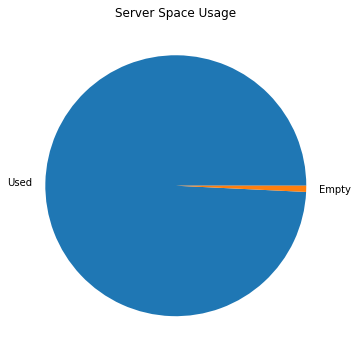

In [23]:
total_space_used(df, server_size=274877906944000)

### How much server space is taken up by each person?

In [24]:
def space_per_user(input_df, server_size=274877906944000):

    #Calculate space per user
    user_files=df.groupby("username")["size"].sum().sort_values(ascending=False)

    #Add the remaining space as "free space"
    user_files=user_files.append(pd.Series([server_size - np.sum(user_files)], ["Free_Space"]), )

    #Barplot
    plt.figure(figsize=(12, 6))
    plt.bar(user_files.index, convert_byte(user_files.values, type="TB"))
    plt.xticks(rotation='vertical')
    plt.xlabel("Usernames")
    plt.ylabel("Terabytes")
    plt.title("Used Storage per Username")
    plt.savefig(os.path.join(output_dir, "Per_User_Storage.pdf"), bbox_inches = "tight")
    plt.show() 

    #Pieplot
    plt.figure(figsize=(8, 16)).tight_layout()
    patches, texts = plt.pie(x=user_files/server_size)
    plt.legend(patches, user_files.index, loc="right", ncol=2, bbox_to_anchor=(1.5,0.5), fontsize =12)
    plt.title("Proportion of Used Storage")
    plt.savefig(os.path.join(output_dir, "Per_User_Storage_Proportion.pdf"), bbox_inches = "tight")
    plt.show()


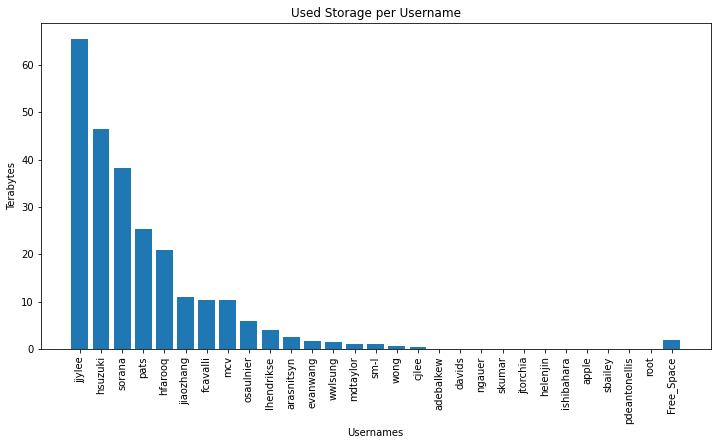

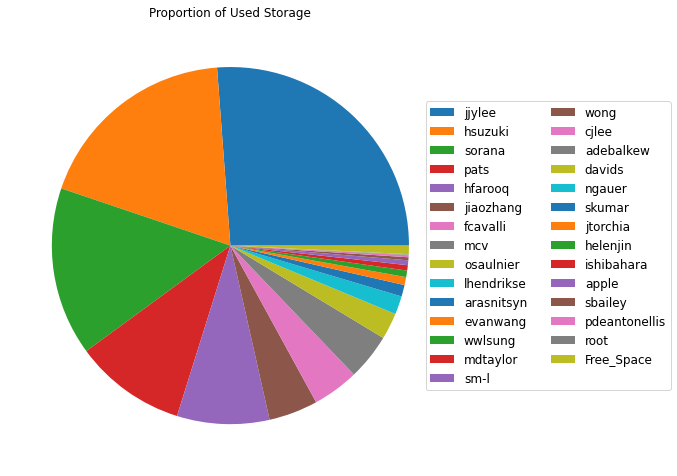

In [25]:
space_per_user(df, server_size=server_size)

### What are the most common file extensions

These are the most common file extensions sorted by size.

In [26]:
df.groupby("extension")["size"].sum().sort_values(ascending=False)/server_size*100

extension
bam          42.705855
gz           22.984401
fastq         5.141176
tmp           4.021131
txt           3.830671
               ...    
o53555493     0.000000
o53555492     0.000000
o53555491     0.000000
o53555490     0.000000
o49127985     0.000000
Name: size, Length: 328810, dtype: float64

The gz extension does not give alot of information about the type of file that was compressed so I will search for some common compressed file types like "fastq.gz" and "txt.gz". Fills without an extension will be set as "unknown".

In [27]:
df.loc[df["name"].str.contains("\.fastq.gz$"), "extension"] = "fastq.gz"
df.loc[df["name"].str.contains("\.vcf.gz$"), "extension"] = "vcf.gz"
df.loc[df["name"].str.contains("\.txt.gz$"), "extension"] = "txt.gz"
df.loc[df["name"].str.contains("\.tar.gz$"), "extension"] = "tar.gz"
df.loc[df["extension"].isnull(), "extension"] = "unknown"

Create a pie of all the common file types.

In [28]:
def extension_piegraph(input_df, output_dir, size, other_threshold_prop=0.005, show_plot=True):
    
    #summed extension size threshold for "other"
    other_threshold=size*other_threshold_prop
    other_rows=(input_df.groupby("extension")["size"].transform('sum') < other_threshold)
    
    #Sum all extensions
    extensions=input_df[["extension","size"]].copy()
    extensions.loc[other_rows, "extension"] = "other"
    extensions=extensions.groupby("extension")["size"].sum().sort_values(ascending=False)
    
    #Barplot
    plt.figure(figsize=(12, 6))
    plt.bar(extensions.index, convert_byte(extensions.values, type="TB"))
    plt.xticks(rotation='vertical')
    plt.xlabel("Extensions")
    plt.ylabel("Terabytes")
    plt.title("File Extension Distribution (Total = {:0.2f}TB)".format(convert_byte(size, type="TB")))
    plt.savefig(os.path.join(output_dir, "File_Extension_Sizes.pdf"), bbox_inches = "tight")
    if show_plot == True:
        plt.show()
    
    #Pieplot
    plt.figure(figsize=(8, 16)).tight_layout()
    patches, texts = plt.pie(x=extensions/size)
    plt.legend(patches, extensions.index, loc="right", ncol=2, bbox_to_anchor=(1.5,0.5), fontsize =12)
    plt.title("File Extension Distribution (Total =  {:0.2f}TB)".format(convert_byte(size, type="TB")))
    plt.savefig(os.path.join(output_dir, "File_Extension_Proportion.pdf"), bbox_inches = "tight")
    if show_plot == True:
        plt.show()

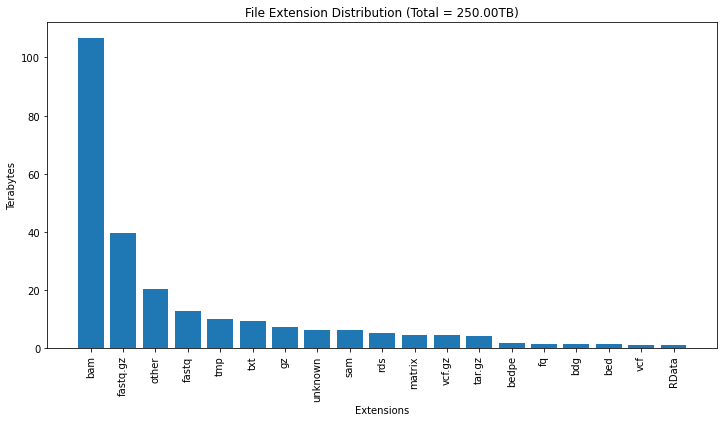

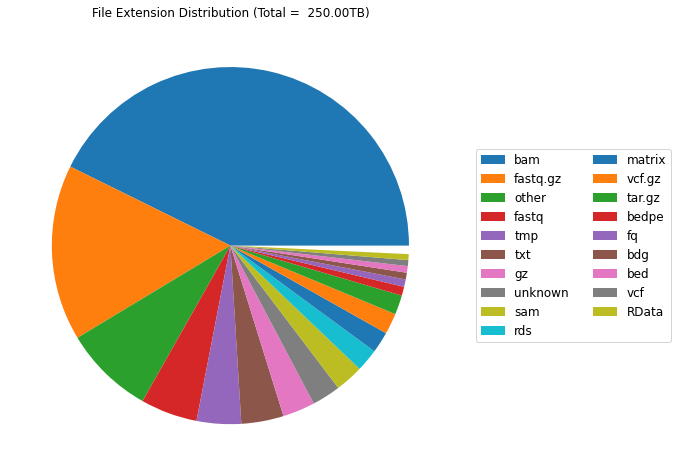

In [29]:
extension_piegraph(df, other_threshold_prop=0.005, output_dir=output_dir, size=server_size)

## Find Compressible/Removable File Candidates

### File Duplicates
There are bound to be many duplicate files that are small. More important to focus on larger duplicate files so I will set a threshold of 100MB. Some of the larger duplicate files were too big to calculate a md5 within the timelimit given. These will be ignored for now.

In [30]:
def server_duplicates(input_df, duplicate_min_size=104857600):
  
    #Mark the true duplicates (md5sums identical)
    duplicates=(input_df.duplicated(subset=["md5sum"], keep=False)) & ~(input_df["md5sum"].str.contains("Error$")) & (input_df["size"] > duplicate_min_size) 
    
    #Mark the possible duplicates (file to large for md5sum but same name/filesize)
    Possible_duplicate=((input_df["md5sum"] == "TimeoutError") & (input_df["size"] >duplicate_min_size) & (input_df.duplicated(subset=["name","size"], keep=False)))
    
    #Duplicate boolean column
    input_df["is_duplicate"]= duplicates | Possible_duplicate
                                                                                    
    #Add the duplicate paths in another column for referenece
    duplicate_mapping=df.loc[df["is_duplicate"] == True].groupby("md5sum")["path"].apply(';'.join).reset_index().rename(columns={'path':'duplicate_paths'})
    input_df=input_df.merge(duplicate_mapping, how="outer", left_on="md5sum", right_on="md5sum")
    
    #Pieplot input
    dup_pie_input=df.groupby("is_duplicate")["size"].sum()
    dup_pie_input.rename(index={True : "Duplicated", False: "Unique"}, inplace=True)
    
    print("{:0.2f}TB ({:0.2f}%) of the server is duplicated".format(dup_pie_input.loc["Duplicated"]/float(1<<40), 
                                                                    dup_pie_input.loc["Duplicated"]/server_size*100))
    
    #Pieplot
    plt.figure(figsize=(8, 16)).tight_layout()
    patches, texts = plt.pie(x=dup_pie_input/server_size)
    plt.legend(patches, dup_pie_input.index, loc="right", ncol=2, bbox_to_anchor=(1.5,0.5), fontsize =12)
    plt.title("Proportion of Used Storage")
    plt.savefig(os.path.join(output_dir, "Duplicated_proportion.pdf"), bbox_inches = "tight")
    plt.show()
    
    return input_df

9.55TB (3.82%) of the server is duplicated


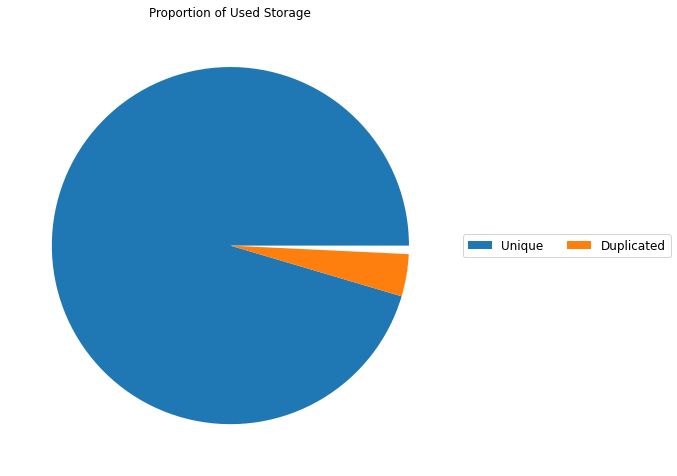

In [31]:
df=server_duplicates(df, duplicate_min_size=104857600)

### Compressible Files

The lowest hanging fruit is to find all the non-compressed fastq, sam, txt, and vcf files. Some of these size can be small and numerous so I will set a miminal size for them to be good candidates. These would make a better impact if they are compressed. Of note, a tar file is a collection of files which is NOT compressed.

In [32]:
def flag_files(input_df, pattern, out_col_name, size_thres, size_col="size", search_col="extension"):

    #Check if the correct input dimensions were given
    if len(pattern) != len(out_col_name):
        raise ValueError('pattern and out_col_name dimensions don\'t match')
    
    #Search in search_col for each element in pattern and output boolean if matched in out_col_name
    concat_ary=[]
    for i in range(0,len(pattern)):
        concat_ary.append((input_df[search_col] == pattern[i]) & (input_df[size_col] > size_thres[i]))
    
    #Combined columns into dataframe
    out_df=pd.concat(concat_ary, axis=1)
    out_df.columns=out_col_name
    
    return out_df


In [33]:
def compressible_pie(input_df, server_size):

    #Pieplot input
    com_pie_input=df.groupby("Compressible")["size"].sum()
    com_pie_input.rename(index={True : "Compressible", False: "Normal"}, inplace=True)

    print("{:0.2f}TB ({:0.2f}%) of the server is compressible".format(com_pie_input.loc["Compressible"]/float(1<<40), 
                                                                    com_pie_input.loc["Compressible"]/server_size*100))

    #Pieplot
    plt.figure(figsize=(8, 16)).tight_layout()
    patches, texts = plt.pie(x=com_pie_input/server_size)
    plt.legend(patches, com_pie_input.index, loc="right", ncol=2, bbox_to_anchor=(1.5,0.5), fontsize =12)
    plt.title("Proportion of Storage Compressible")
    plt.savefig(os.path.join(output_dir, "Compressible_proportion.pdf"), bbox_inches = "tight")
    plt.show()

34.94TB (13.98%) of the server is compressible


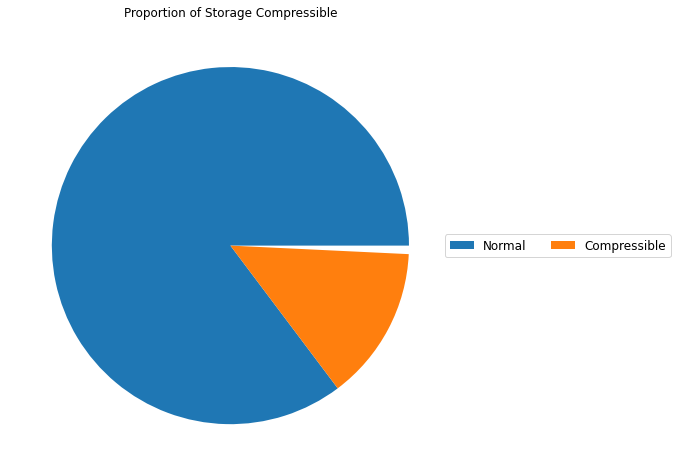

In [34]:
flagged_files=flag_files(df, pattern=['fastq', 'sam', 'vcf', 'txt', 'tar','tmp'], 
                         out_col_name=["fastq_com", "sam_com", "vcf_com", "txt_com", "tar_com", "tmp_com"], 
                         size_thres=[524288000, 524288000, 524288000, 524288000, 524288000, 524288000], 
                         search_col="extension")

#Flag anyfile with one of the flags as compressible
df["Compressible"]=np.any(flagged_files, axis=1)

#Piegraph
compressible_pie(df, server_size)

### Per User Distributions
The file extension matched are all mutually exclusive but the duplicates can overlap with anything. I will set the precedence for duplicate over all the other flags. Any file flagged duplicate will have the other flags removed.

In [35]:
def files_to_fix_per_user(flagged, input_df):

    #Add the duplicate column and make it take presedence over the extension flags
    flagged.loc[(np.any(flagged, axis=1) & (input_df["is_duplicate"] == True))] = False
    flagged["is_duplicate"]=input_df["is_duplicate"] 
    
    #Sum up each of the flags for each username
    size_sums=[]
    for col in flagged.columns:
        size_sums.append(input_df.loc[flagged[col]].groupby("username")["size"].sum().rename(col))
    file_types=pd.concat(size_sums, axis=1).fillna(value=0)

    #Sum up all the flag file sizes
    file_types=file_types.merge(file_types.sum(axis=1).rename("flags_Total"), how="outer",left_index=True, right_index=True)

    #Calculate the total space used per user
    file_types=file_types.merge(input_df.groupby("username")["size"].sum().rename("Total"),how="outer",left_index=True, right_index=True)
    file_types["not_flagged"]=file_types["Total"] - file_types["flags_Total"]

    #Convert to Terabytes
    file_types=file_types.sort_values("Total", ascending=False)/float(1<<40)

    #Plot a stacked bar plot
    plt.figure()
    file_types.drop(columns=["Total","flags_Total"]).plot(kind="bar",stacked=True, figsize=(15,6))
    plt.xlabel('Username')
    plt.ylabel('Terabytes')
    plt.title("Flagged Files Per User")
    plt.savefig(os.path.join(output_dir, "Per_user_flagged.pdf"), bbox_inches = "tight")
    plt.show()

<Figure size 432x288 with 0 Axes>

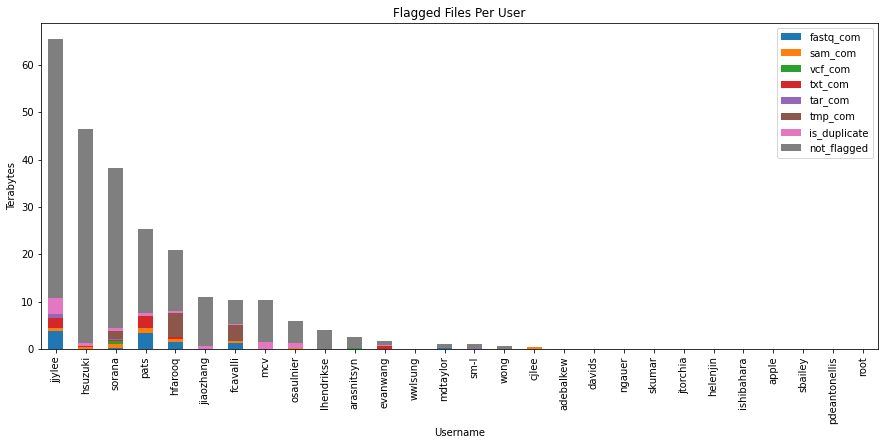

In [36]:
files_to_fix_per_user(flagged_files, df)

## Report

Creat a seperate folder for each username and creat a pie chart of file types 

jjylee
hfarooq
pats
mcv
sorana
hsuzuki
jiaozhang
sm-l
osaulnier
wong
lhendrikse


<ipython-input-28-f7b447f726ec>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))
<ipython-input-28-f7b447f726ec>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 16)).tight_layout()


wwlsung


<ipython-input-28-f7b447f726ec>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))
<ipython-input-28-f7b447f726ec>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 16)).tight_layout()


mdtaylor


<ipython-input-28-f7b447f726ec>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))
<ipython-input-28-f7b447f726ec>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 16)).tight_layout()


fcavalli


<ipython-input-28-f7b447f726ec>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))
<ipython-input-28-f7b447f726ec>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 16)).tight_layout()


evanwang


<ipython-input-28-f7b447f726ec>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))
<ipython-input-28-f7b447f726ec>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 16)).tight_layout()


cjlee


<ipython-input-28-f7b447f726ec>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))
<ipython-input-28-f7b447f726ec>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 16)).tight_layout()


arasnitsyn


<ipython-input-28-f7b447f726ec>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))
<ipython-input-28-f7b447f726ec>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 16)).tight_layout()


skumar


<ipython-input-28-f7b447f726ec>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))
<ipython-input-28-f7b447f726ec>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 16)).tight_layout()


ishibahara


<ipython-input-28-f7b447f726ec>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))
<ipython-input-28-f7b447f726ec>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 16)).tight_layout()


jtorchia


<ipython-input-28-f7b447f726ec>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))
<ipython-input-28-f7b447f726ec>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 16)).tight_layout()


davids


<ipython-input-28-f7b447f726ec>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))
<ipython-input-28-f7b447f726ec>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 16)).tight_layout()


ngauer


<ipython-input-28-f7b447f726ec>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))
<ipython-input-28-f7b447f726ec>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 16)).tight_layout()


adebalkew


<ipython-input-28-f7b447f726ec>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))
<ipython-input-28-f7b447f726ec>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 16)).tight_layout()


helenjin


<ipython-input-28-f7b447f726ec>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))
<ipython-input-28-f7b447f726ec>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 16)).tight_layout()


apple


<ipython-input-28-f7b447f726ec>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))
<ipython-input-28-f7b447f726ec>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 16)).tight_layout()


sbailey


<ipython-input-28-f7b447f726ec>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))
<ipython-input-28-f7b447f726ec>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 16)).tight_layout()


pdeantonellis


<ipython-input-28-f7b447f726ec>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))
<ipython-input-28-f7b447f726ec>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 16)).tight_layout()


root


<ipython-input-28-f7b447f726ec>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))
<ipython-input-28-f7b447f726ec>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 16)).tight_layout()


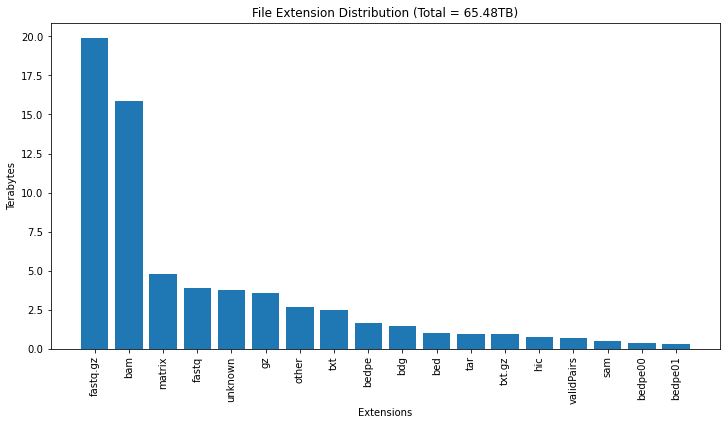

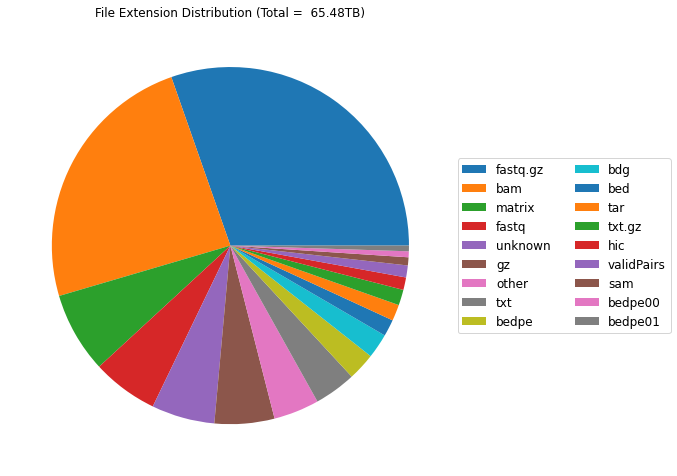

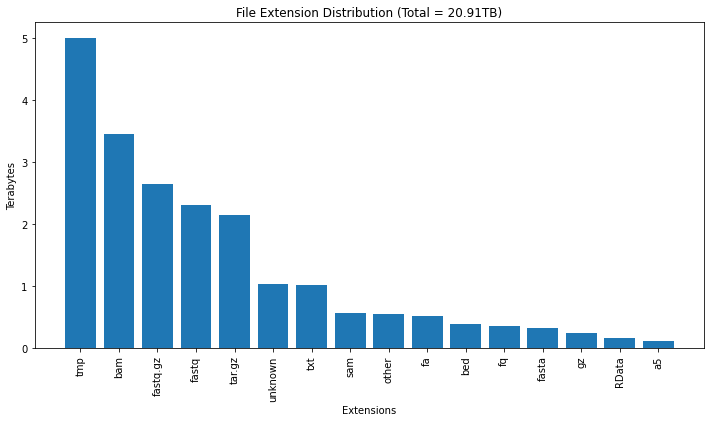

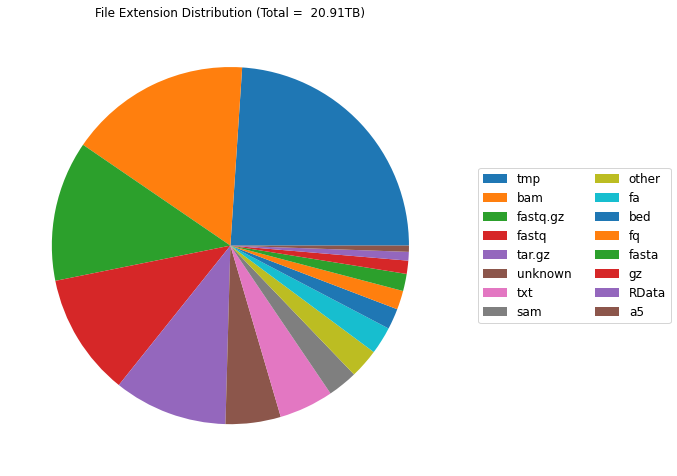

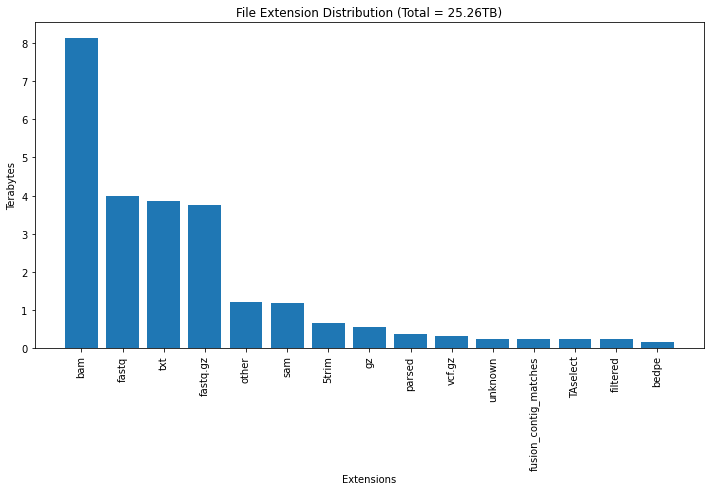

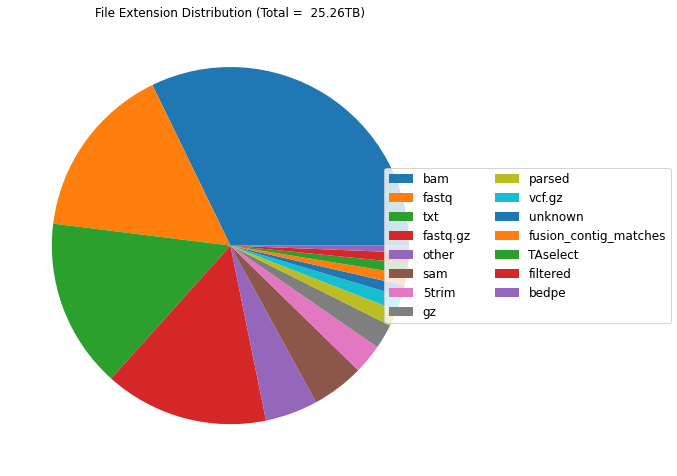

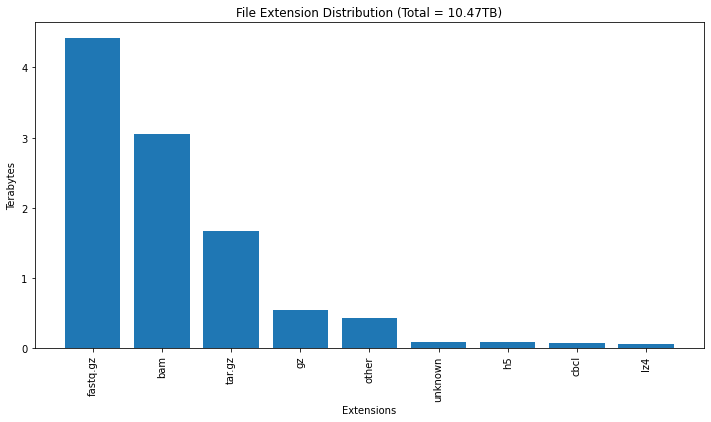

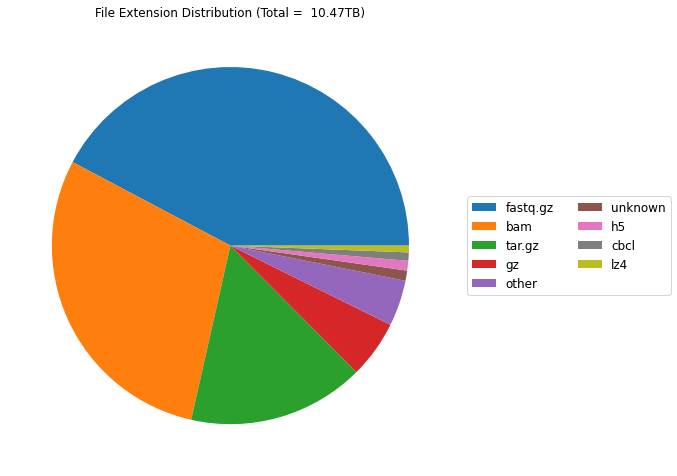

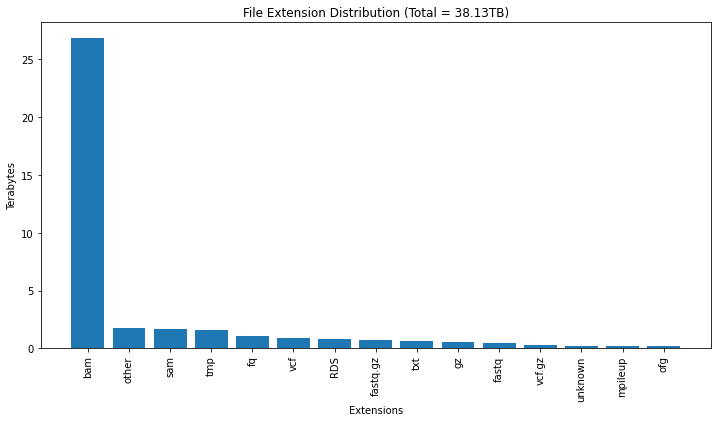

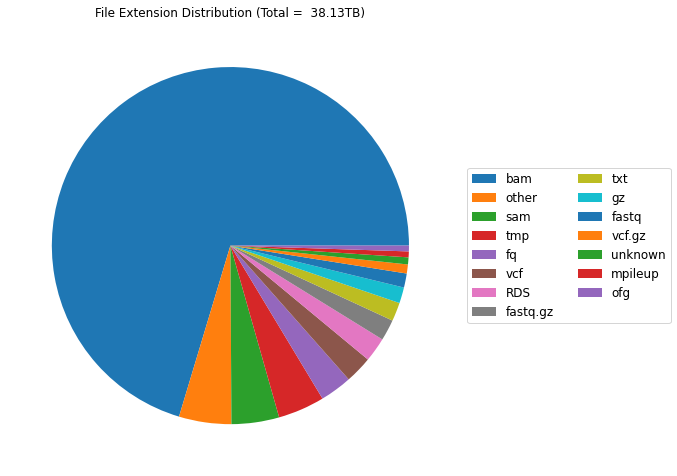

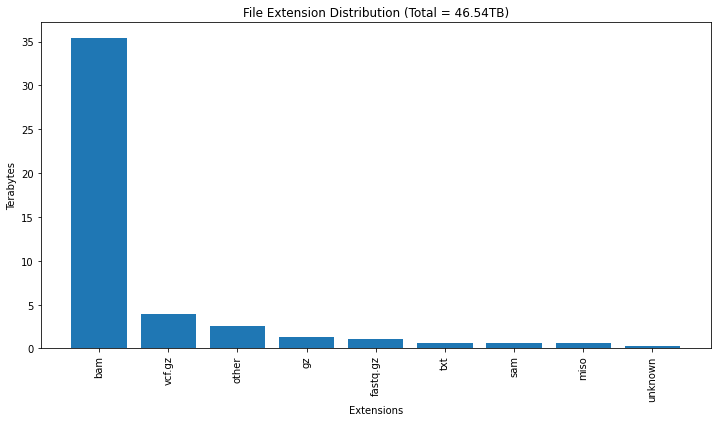

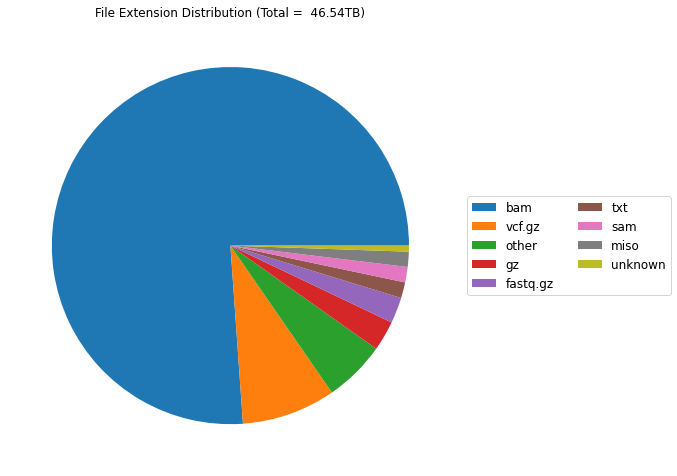

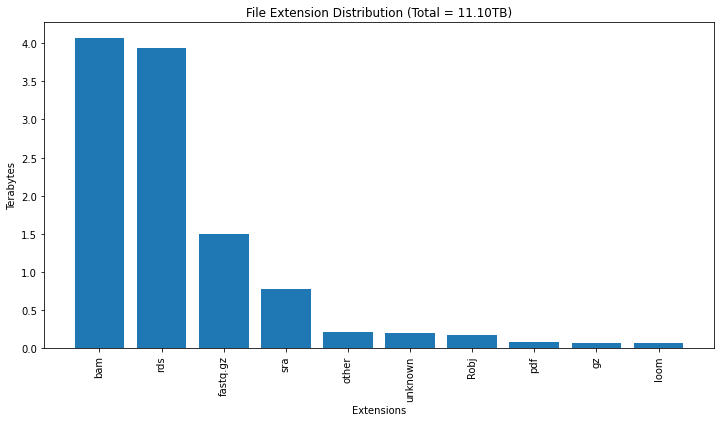

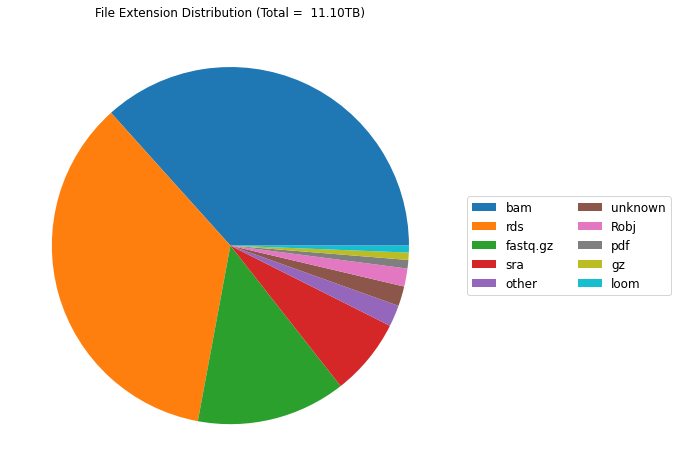

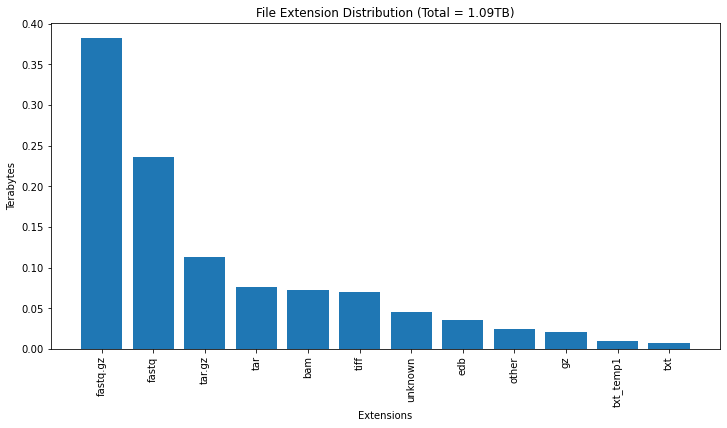

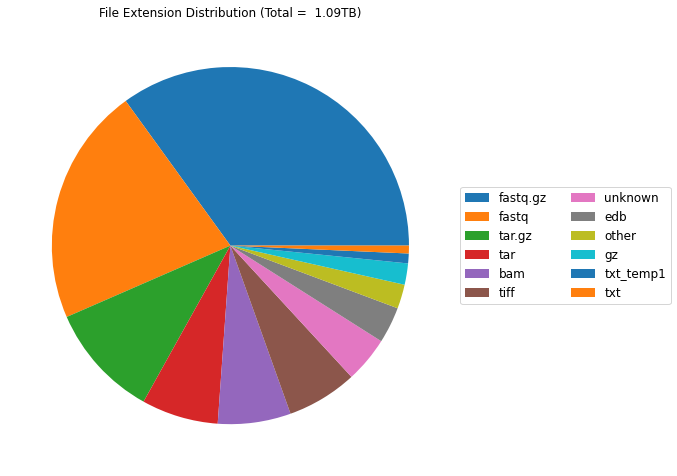

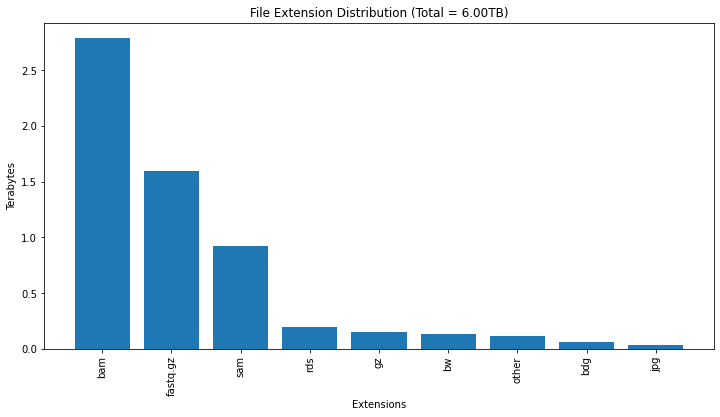

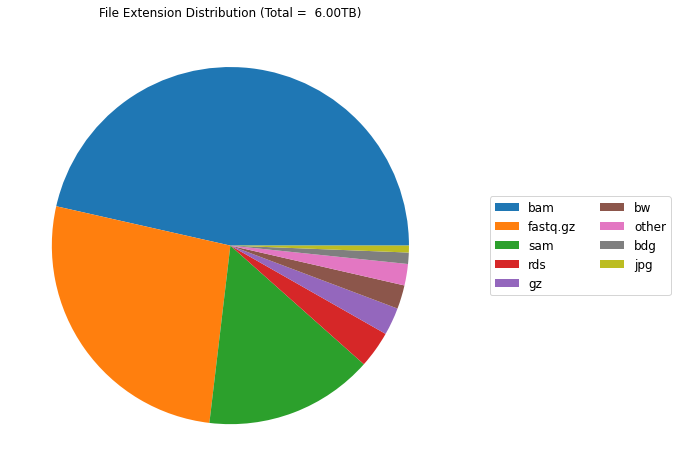

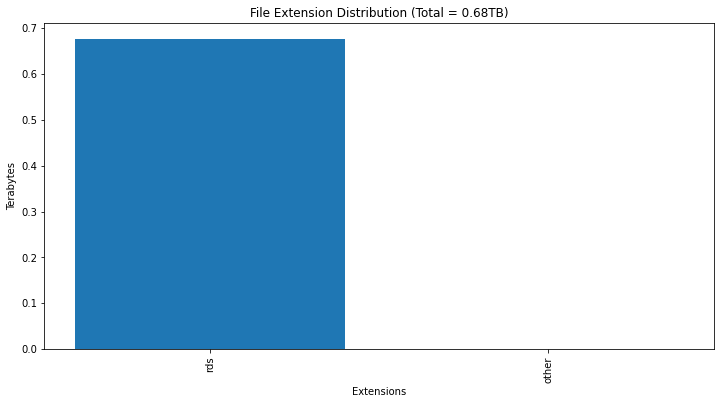

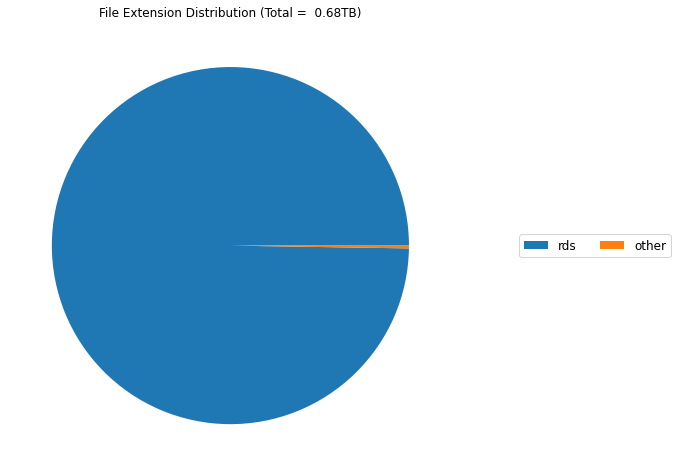

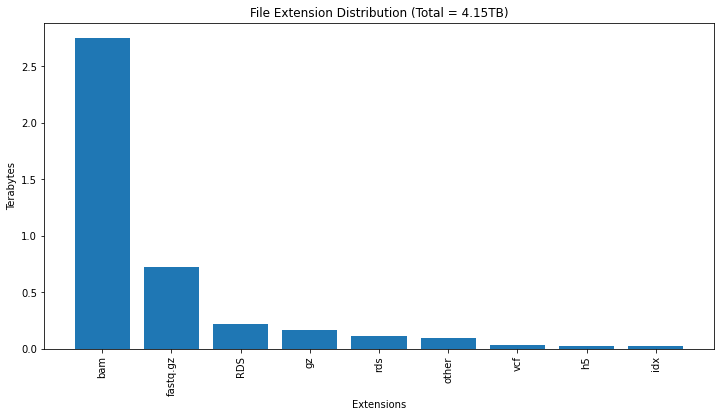

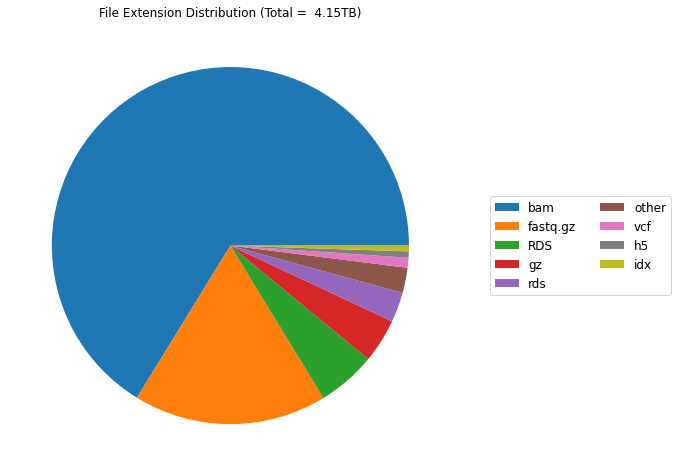

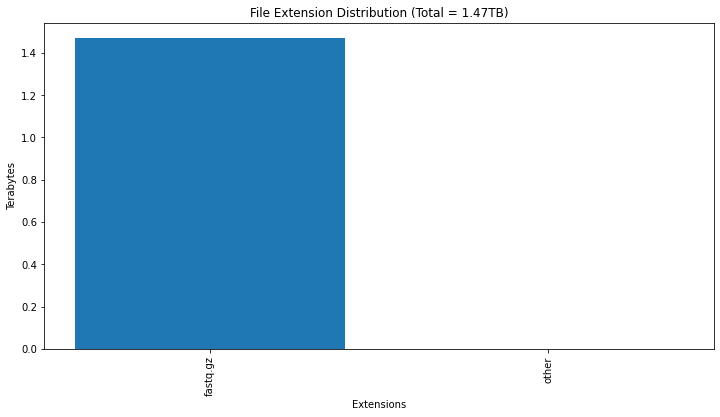

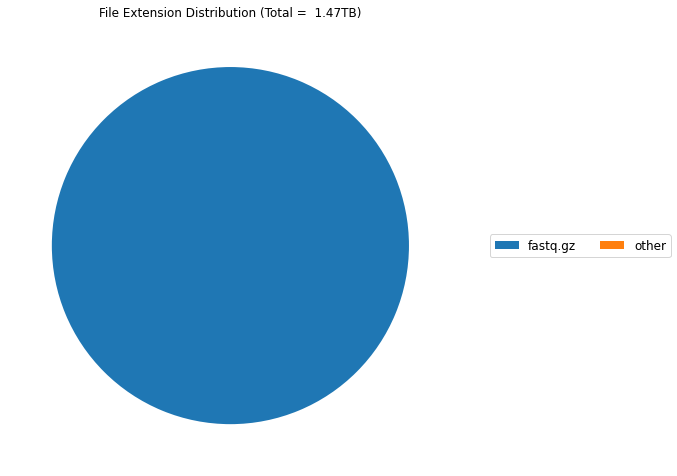

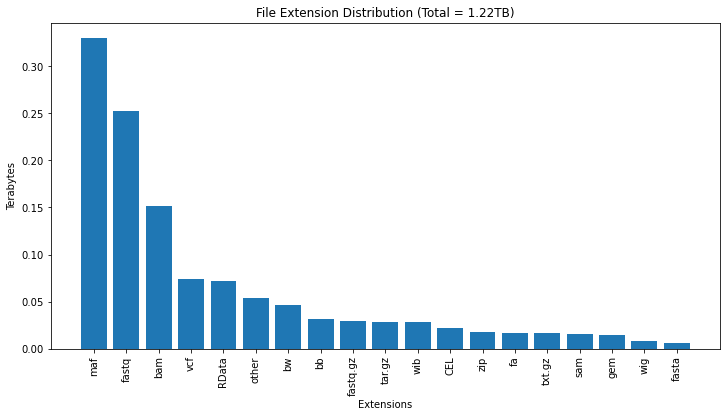

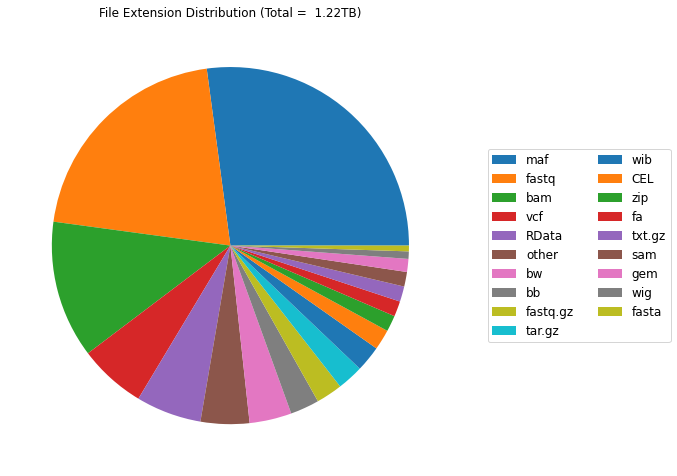

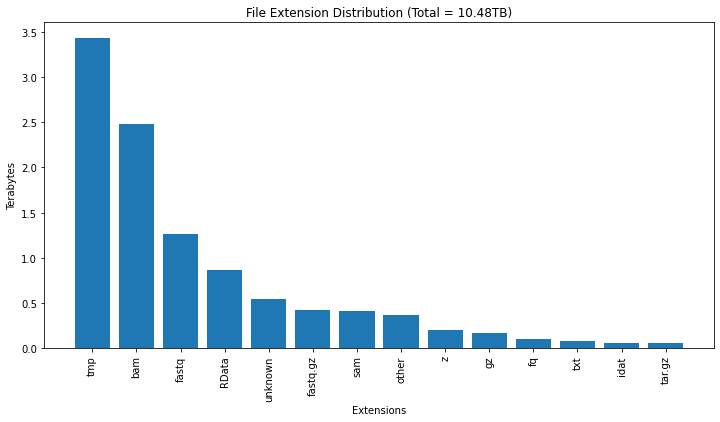

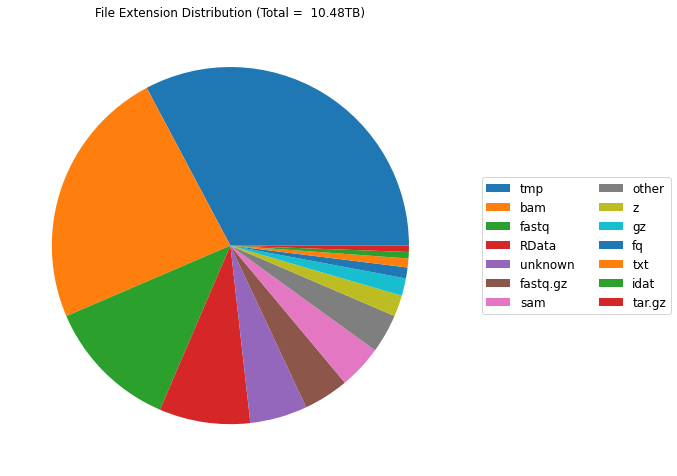

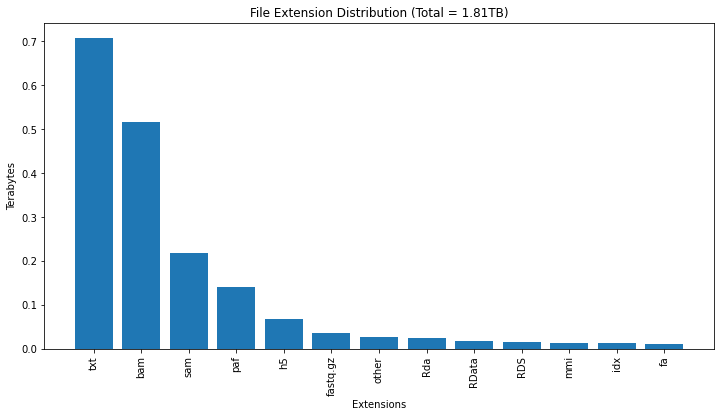

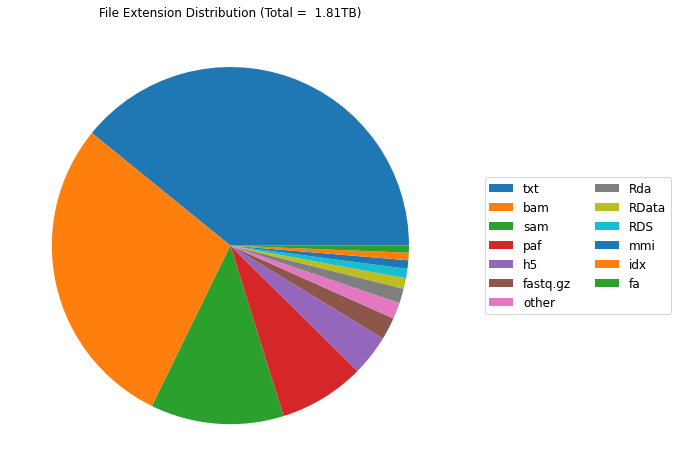

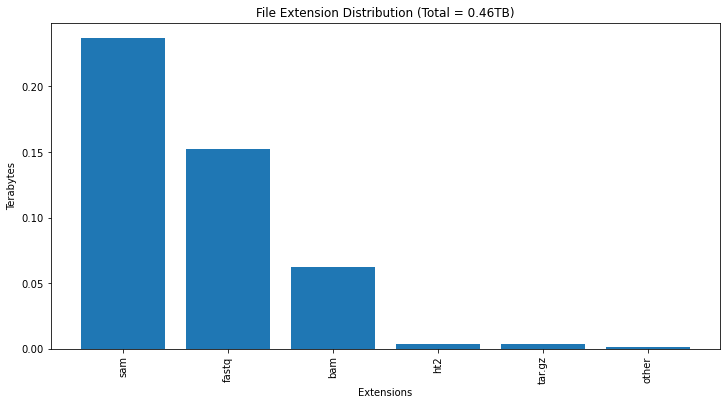

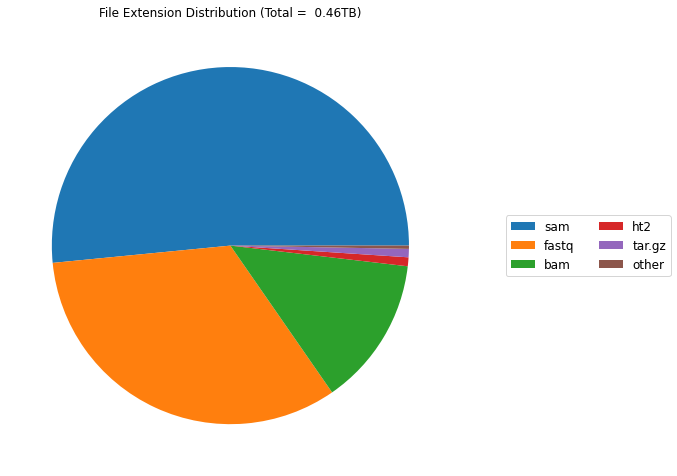

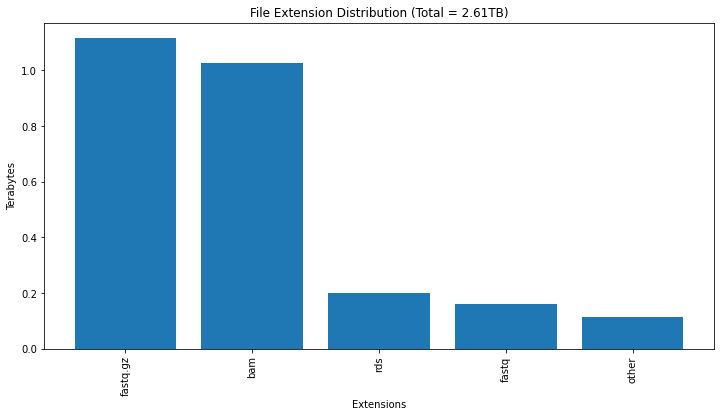

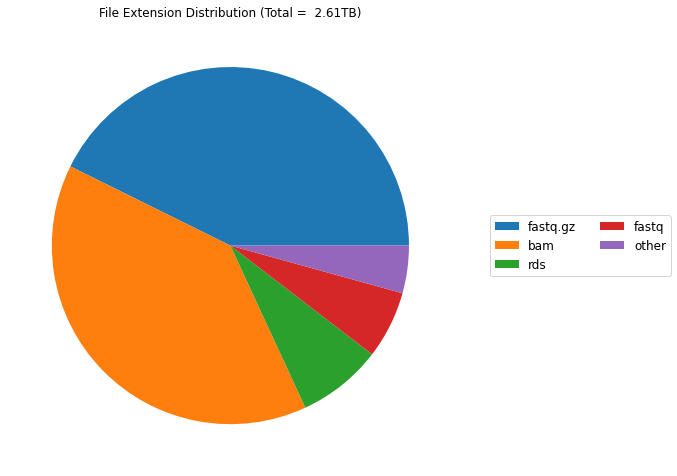

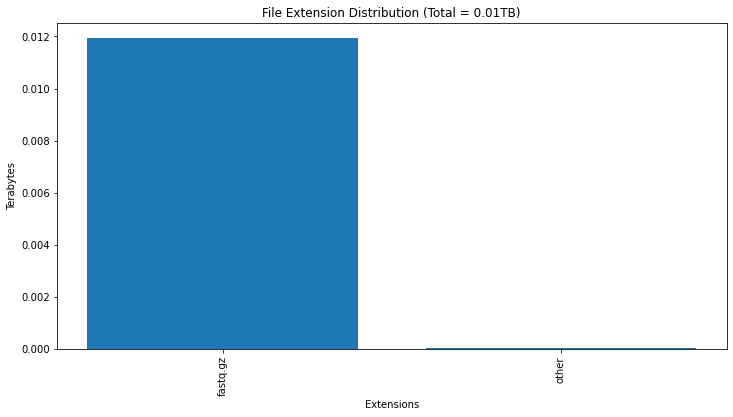

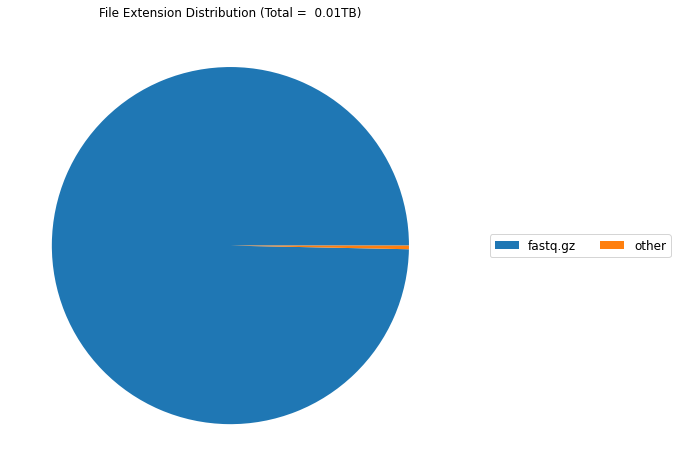

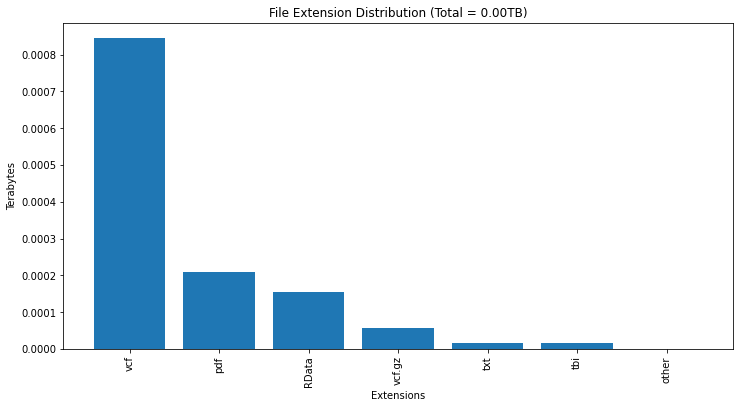

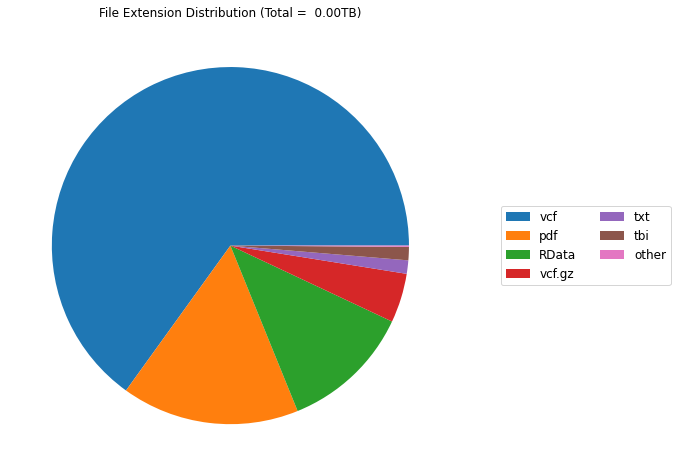

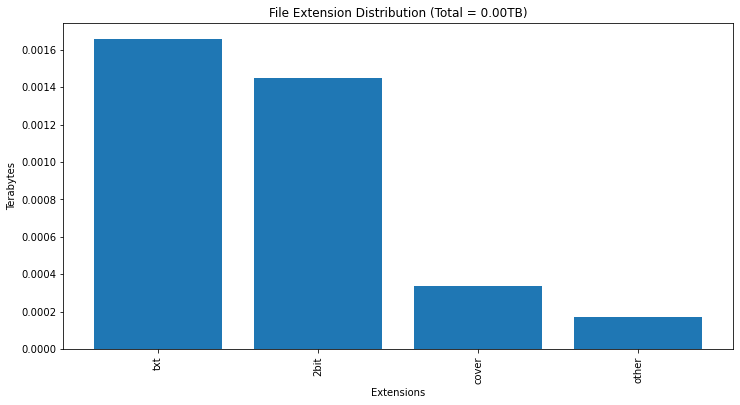

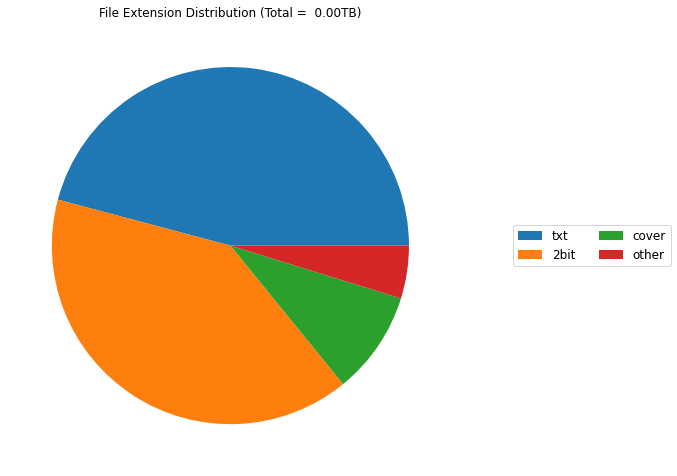

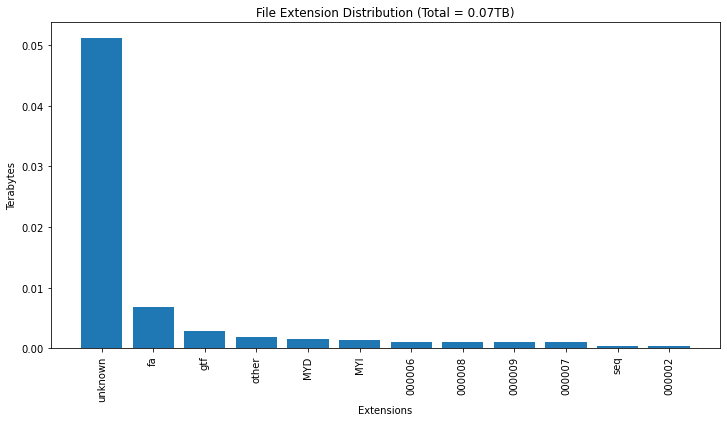

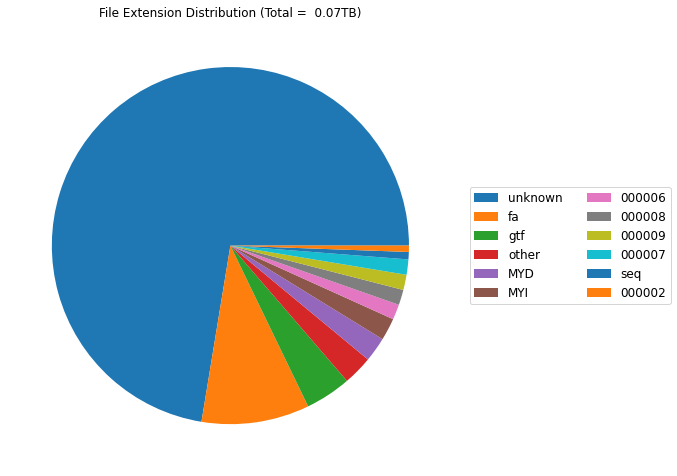

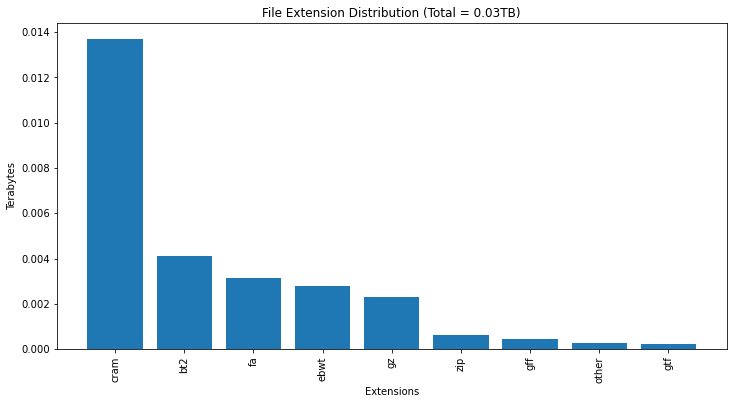

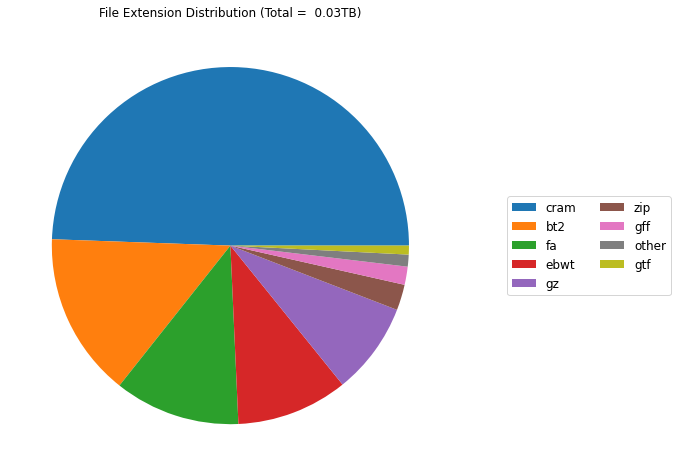

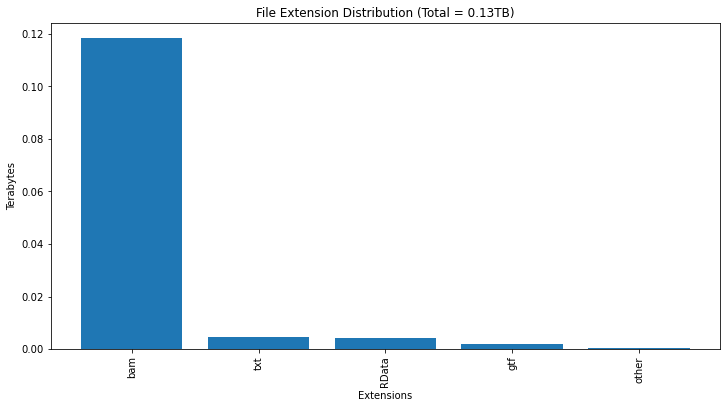

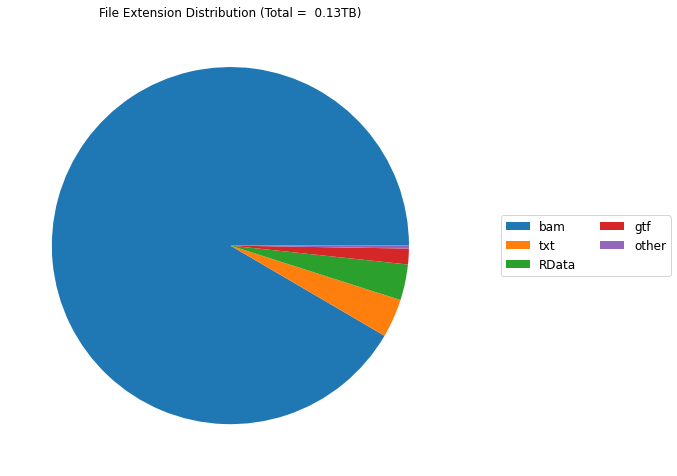

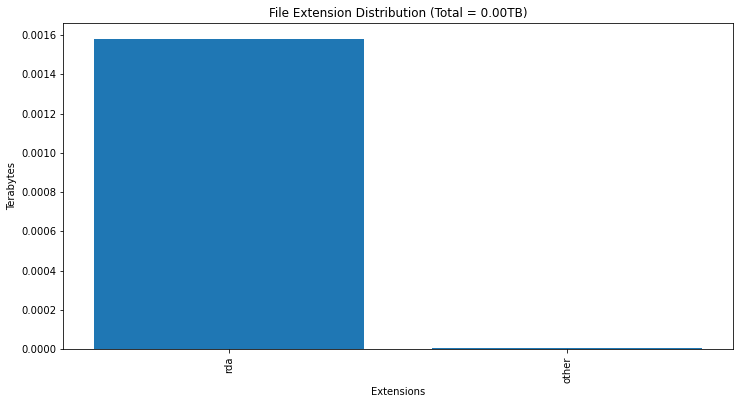

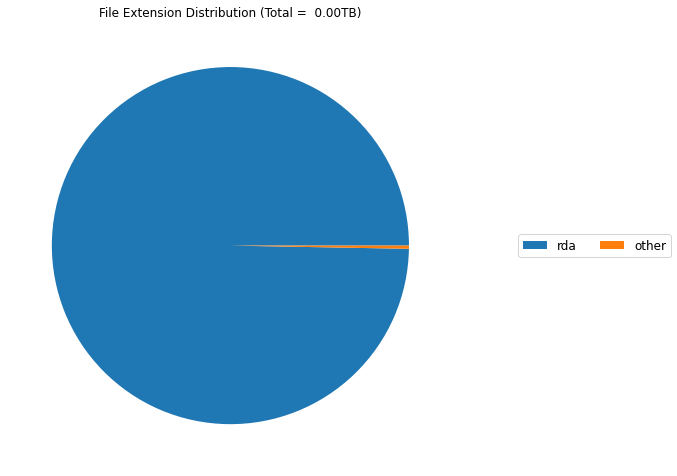

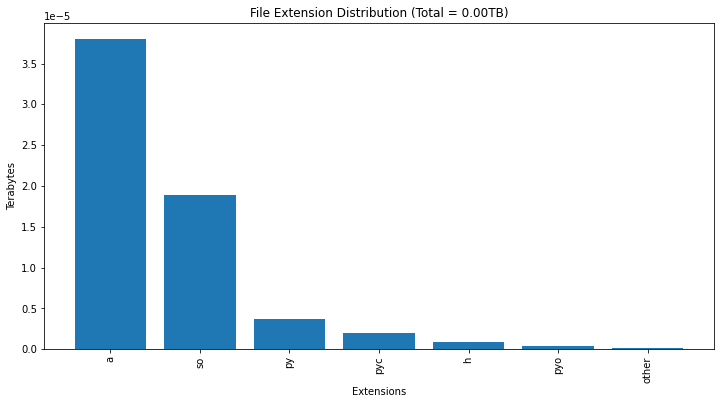

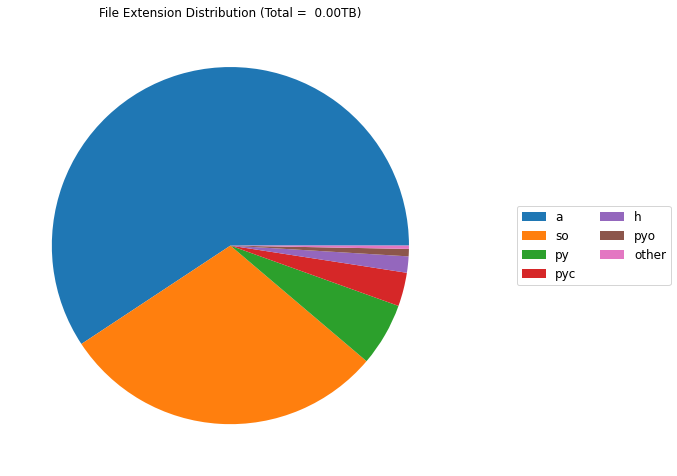

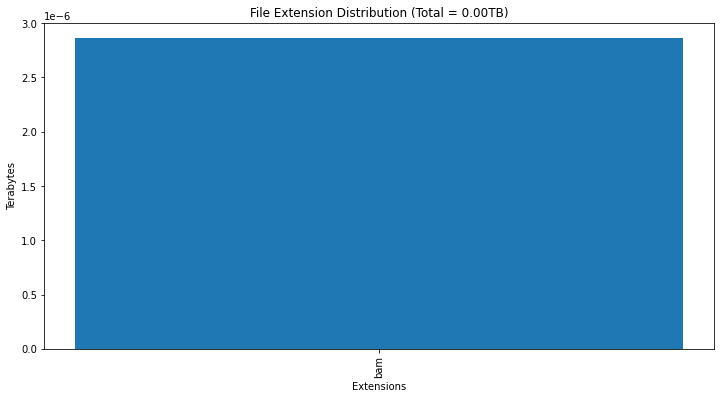

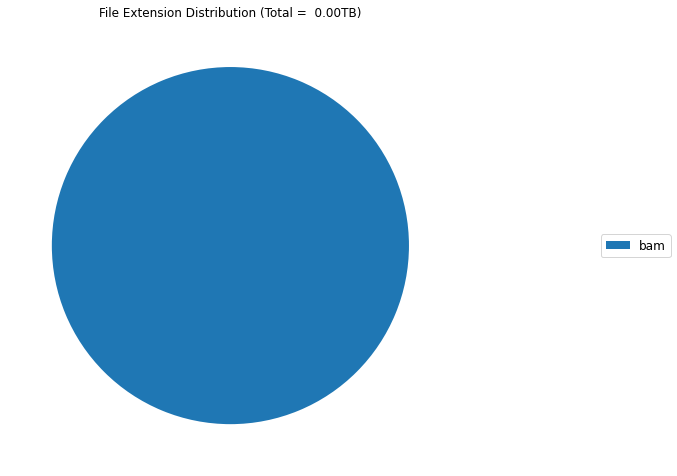

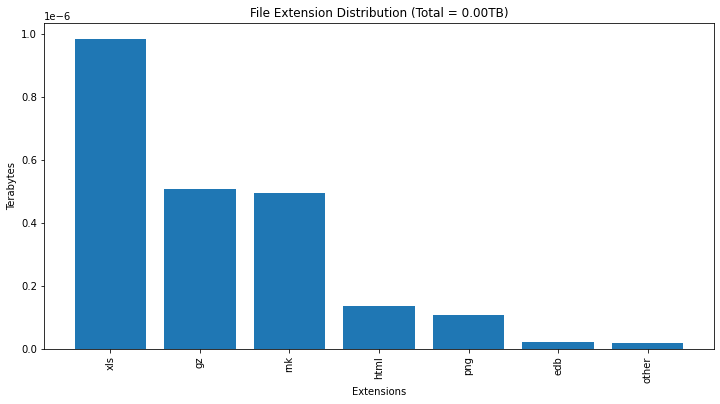

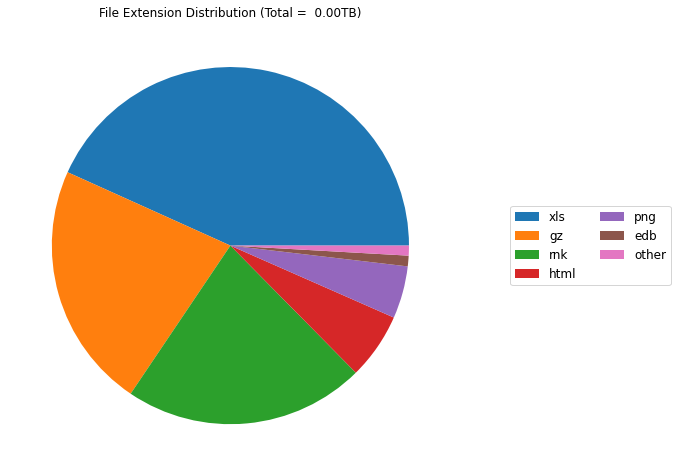

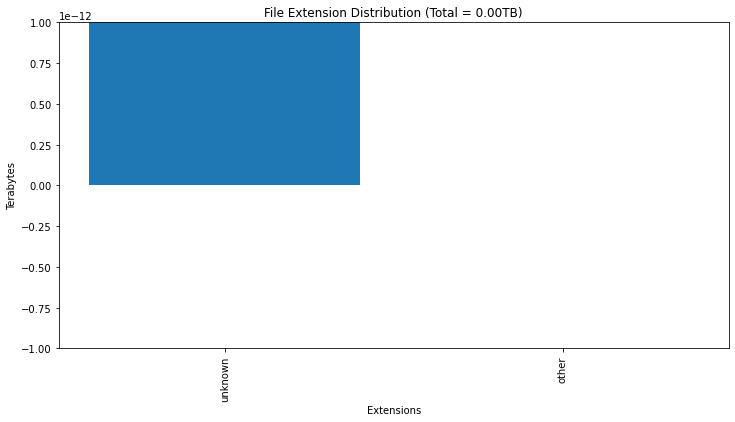

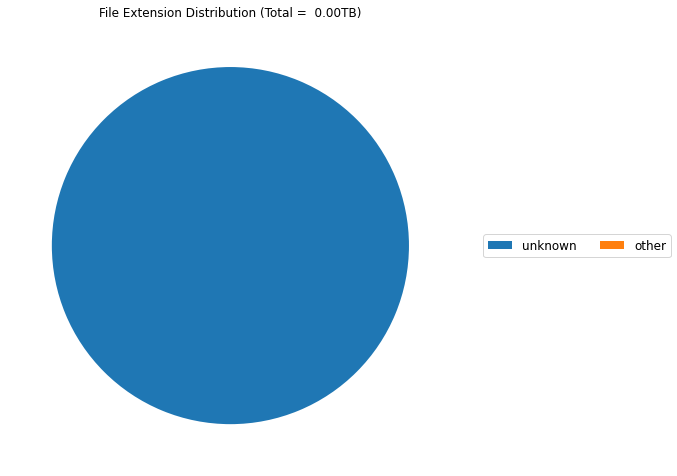

In [37]:
for user in df["username"].unique():
    
    print(user)

    #Create a Folder
    user_output_folder=os.path.join(output_dir,"User_Reports",user)
    if not os.path.exists(user_output_folder):
        os.makedirs(user_output_folder)

    #Subset on user
    output=df.loc[(df["username"] == user)]

    #Flagged Files
    out_col=["username","path","hsize","is_duplicate","Compressible","duplicate_paths"]   
    output.loc[((df["is_duplicate"] == True) | (df["Compressible"] == True)), out_col].to_csv(
        os.path.join(user_output_folder,"{}_flagged_files.txt.gz".format(user)), sep="\t",index=False, compression="gzip")

    #All Files
    out_col=["username","path","name","extension","size","hsize","md5sum"]   
    output.loc[df["username"] == user,out_col].to_csv(os.path.join(user_output_folder,"{}_All_files.txt.gz".format(user)), 
                                           sep="\t", index=False, compression="gzip")

    #Pie chart
    extension_piegraph(input_df=df.loc[df["username"] == user,], output_dir=user_output_folder, 
                       other_threshold_prop=0.005, size=output["size"].sum(), show_plot=False)


### All fastq and bam files

In [38]:
#Add a folderpath column to the data
df["foldername"]=df["path"].apply(os.path.dirname)

In [39]:
out_col=["username","foldername","name","hsize","size","is_duplicate","duplicate_paths"]
df.loc[df["extension"].isin(["fastq","fastq.gz"]), out_col].to_csv(os.path.join(output_dir,"fastq_files.txt"), sep="\t",index=False)

In [40]:
out_col=["username","foldername","name","hsize","size","is_duplicate","duplicate_paths"]
df.loc[df["extension"].isin(["bam","cram","sam"]), out_col].to_csv(os.path.join(output_dir,"bam_files.txt"), sep="\t",index=False)

### Flagged Files Report
Create a combined report of all the flagged files as well as one report split per user.

In [41]:
#All flagged files
out_col=["username","path","hsize","is_duplicate","Compressible","duplicate_paths"]    
output=df.loc[(df["is_duplicate"] == True) | (df["Compressible"] == True), out_col]
output.to_csv(os.path.join(output_dir,"All_flagged_files.txt"), sep="\t",index=False)

# Personal Cleanup

In [43]:
#Size of the RNAseq alignment folders and intermediate files
find=df["path"].str.contains("/hpf/largeprojects/mdtaylor/RNA-Seq/fastq_files/MDT-AP.*/.*")
convert_byte(df.loc[find,"size"].sum())

24.592210418846662

In [44]:
#Size of Infusion Intermediate files (DELETED)
find=df["path"].str.contains("/hpf/largeprojects/mdtaylor/RNA-Seq/fastq_files/.*/infusion")
convert_byte(df.loc[find,"size"].sum())

6.460961250042601

In [45]:
#Size of the STAR fusion intermediate files
find=df["path"].str.contains("/hpf/largeprojects/mdtaylor/RNA-Seq/fastq_files/.*\.Fusions/.*")
convert_byte(df.loc[find,"size"].sum())

1.5867737284124814

In [46]:
#Size of the RNAseq project aligned bam file
find=df["path"].str.contains("/hpf/largeprojects/mdtaylor/RNA-Seq/fastq_files/.*Aligned.sortedByCoord.out.bam")
convert_byte(df.loc[find,"size"].sum())

13.465671719956845

In [47]:
#Size of the STAR chimeric sam files
find=df["path"].str.contains("/hpf/largeprojects/mdtaylor/RNA-Seq/fastq_files/.*Chimeric.out.sam")
convert_byte(df.loc[find,"size"].sum())

0.42636048605254473

In [48]:
#Size of the vcf files in RNAseq directory
find=df["path"].str.contains("/hpf/largeprojects/mdtaylor/RNA-Seq/fastq_files/.*vcf")
convert_byte(df.loc[find,"size"].sum())

0.09476829971663392

In [49]:
#SB Project Directories
find=df["path"].str.contains("/hpf/largeprojects/mdtaylor/Mouse_Work/Insertional_mutagenesis_data")
convert_byte(df.loc[find,"size"].sum())

8.466766107357216

In [50]:
#LP RNAseq run
find=df["path"].str.contains("/hpf/largeprojects/mdtaylor/Mouse_Work/Lazy_Piggy_RNAseq")
convert_byte(df.loc[find,"size"].sum())

0.03048193186350545

In [58]:
find=df["path"].str.contains("/hpf/largeprojects/mdtaylor/Mouse_Work/Insertional_mutagenesis_data/Lazy_Piggy/")
convert_byte(df.loc[find,"size"].sum())

5.160185560136597